<a href="https://colab.research.google.com/github/villasen/colab_notebooks/blob/master/20Classes_ESC_50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




### Download prepared ESC-50-splitted 16KHz sampled with silence removed from all files
The script will point to the preprocessed files located in /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz

In [2]:
!git clone https://github.com/villasen/small-urban-sound-dataset
!rm -r sample_data

Cloning into 'small-urban-sound-dataset'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 35345 (delta 54), reused 70 (delta 32), pack-reused 35251
Receiving objects: 100% (35345/35345), 977.46 MiB | 42.15 MiB/s, done.
Resolving deltas: 100% (12686/12686), done.
Checking out files: 100% (43959/43959), done.


### Select number of mfccs to run

In [0]:
MFCC=10
NUM_CLASSES=20

### Pulling libraries and defining functions

In [4]:
import keras
from keras import layers
from keras import models
from keras import backend as K
from keras import optimizers
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import numpy as np
import librosa
import librosa.display
import tensorflow
import scipy
import os, shutil
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import urllib
import sys
import tarfile
import os.path
from os import path
from tensorflow.python.ops import io_ops
from tensorflow.contrib.framework.python.ops import audio_ops as contrib_audio
import matplotlib.pyplot as plt
import librosa.display

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from numpy  import array
from tensorflow.contrib.quantize.python import fold_batch_norms
from tensorflow.contrib.quantize.python import quantize
from tensorflow.python.framework import ops
print(tf.__version__)






########### FUNCTIONS

def urban_wav2mfcc(file_path, max_pad_len):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      
    pad_width = max_pad_len - mfcc.shape[1]
    #print(max_pad_len)
    #print(mfcc.shape[1])
    #print(pad_width)
    if pad_width < 0: 
      print(mfcc.shape[1])
      print(pad_width)
      print("error in "+ file_path)
    
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc 


  
  
def load_wav_file(wav_file):
  with tf.Session(graph=tf.Graph()) as sess:
      wav_filename_placeholder = tf.placeholder(tf.string, [])
      wav_loader = io_ops.read_file(wav_filename_placeholder)
      wav_decoder = contrib_audio.decode_wav(wav_loader, desired_channels=1)
      return sess.run(
          wav_decoder,
          feed_dict={wav_filename_placeholder: wav_file}).audio.flatten()


def get_mfccs(file):
  try:
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320, norm='ortho')
      mfcc_scaled = np.mean(mfcc.T, axis=0)
      
  except Exception as error:
    print("Error found handling file: ", file)
    return None
  
  return mfcc_scaled
      
def normalize_data(mfcc_file, mean, std_dev ):
  norm_file = (mfcc_file - (mean)) / std_dev
  return norm_file



class AudioAugmentation:
    def read_audio_file(self, file_path):
        input_length = 16000
        data = librosa.core.load(file_path)[0]
        if len(data) > input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
        return data

    def write_audio_file(self, file, data, sample_rate=16000):
        librosa.output.write_wav(file, data, sample_rate)

    def add_noise(self, data):
            noise = np.random.randn(len(data))
            data_noise = data + 0.005 * noise
            return data_noise
    def shift(self, data):
            return np.roll(data, 1600)
    def stretch(self, data, rate=1):
            input_length = 16000
            data = librosa.effects.time_stretch(data, rate)
            if len(data) > input_length:
                data = data[:input_length]
            else:
                data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
            return data
    def plot_time_series(self, data):
            fig = plt.figure(figsize=(10, 10))
            plt.title('Raw wave ')
            plt.ylabel('Amplitude')
            plt.plot(np.linspace(0, 1, len(data)), data)
            plt.show()

Using TensorFlow backend.


1.15.0


Download nightly version of tensorflow. Only use in case Tensorflow gets updated to 2.0 by default. This is not needed as of now 10/26/2019. When downloading this version, runtime needs to be  reset. Do it twice. First time produces an error.

In [0]:
!pip install --upgrade tensorflow-gpu
# Installing tf version 1.15
! pip uninstall -y tensorflow
#! pip install -U tf-nightly
!pip install tf-nightly==1.15.0.dev20190821
!rm -rf /tmp/urban_sound_models

### Function to build model. More layers can be added by repeating middle block

In [0]:
# Original model
def build_urban_model():
 return keras.Sequential([

# CNN layer     
    #keras.layers.Conv2D(64, (4,MFCC), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),     
    keras.layers.Conv2D(64, (MFCC,4), strides=(2,2), padding='same', activation='relu',  input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),
# Depthwise layers - middle block . +++++++++++++++++++++++++
    keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None), 
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

#+++++++++++++++++++++++++++++++
     
# final layer includes a averagepool and a dense layer     
    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),  activation='relu'),

     
## final layer, here number 6 is the number of classes. If more classes added this number needs to be changed
    keras.layers.Dense(4, activation='softmax')     
      
      


 
 
 ])  


In [0]:
def build_urban_model():
 return keras.Sequential([
      
   # keras.layers.Conv2D(64, (4,MFCC), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),     
    keras.layers.Conv2D(64, (MFCC,4), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),
# Depthwise layers
    keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

# Depthwise layers
    #keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

# Depthwise layers
    
  #  keras.layers.SeparableConv2D(128, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    
  #  keras.layers.Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    
# Depthwise layers
    
   # keras.layers.SeparableConv2D(128, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    
   # keras.layers.Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),




    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
   # keras.layers.Dropout(0.5),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),  activation='relu'),
  
      
    keras.layers.Dense(NUM_CLASSES, activation='softmax')     
      
      
  ]) 

In [0]:
def build_urban_model():
 return keras.Sequential([
      
   # keras.layers.Conv2D(64, (4,MFCC), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),     
    keras.layers.Conv2D(64, (MFCC,4), strides=(2,2), padding='same', activation='relu', input_shape=(MFCC,51,1), kernel_regularizer=keras.regularizers.l2(0.001)),
# Depthwise layers
    keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

# Depthwise layers
    #keras.layers.Dropout(0.5), 
    keras.layers.SeparableConv2D(64, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

# Depthwise layers
    
    keras.layers.SeparableConv2D(128, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),
# Depthwise layers
    
   # keras.layers.SeparableConv2D(128, (3,3), strides=(1,1), data_format='channels_last', padding='same', depth_multiplier=1, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    #keras.layers.Dropout(0.5),
   # keras.layers.Conv2D(128, (1,1), strides=(1,1), padding='same', use_bias=False, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
   # keras.layers.Dropout(0.5),



    keras.layers.AveragePooling2D(pool_size=(5, 25), strides=(2,2), padding='valid', data_format=None),
   # keras.layers.Dropout(0.5),
    keras.layers.Flatten(data_format=None),
   # keras.layers.Dropout(0.5),
    keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001),  activation='relu'),
  
      
    keras.layers.Dense(NUM_CLASSES, activation='softmax')     
      
      
  ])

### Preparing test files
This will create folders 1) test_single_file, 2) target_npy_files 3) target_txt_files

1) test_single_file
    This folder contains

In [6]:
import tensorflow as tf
tf.enable_eager_execution()
import os.path
from os import path




DATA_PATH= '/content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/'



labels = os.listdir('small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/')
print(labels)

test_single_file = '/content/test_single_file/'
if path.exists('/content/test_single_file/') :
    print ("folder test_single exits, removing")
    !rm -rf /content/test_single_file
os.mkdir(test_single_file)

target_npy_files = "/content/target_npy_files/"
if path.exists("/content/target_npy_files/") :
    print ("folder target_npy_files exits, removing")
    !rm -rf /content/target_npy_files
os.mkdir(target_npy_files)


target_txt_files = "/content/target_txt_files/"
if path.exists("/content/target_txt_files/") :
    print ("folder target_txt_files folder exits, removing")
    !rm -rf /content/target_txt_files
os.mkdir(target_txt_files)




# dog
if path.exists("/content/test_single_file/dog") :
     print ("folder test_single_file/dog exits, removing")
     !rm -rf /content/test_single_file/dog
os.mkdir('/content/test_single_file/dog')


# clapping
if path.exists("/content/test_single_file/clapping") :
     print ("folder test_single_file/clapping exits, removing")
     !rm -rf /content/test_single_file/clapping
os.mkdir('/content/test_single_file/clapping')

# door knock
if path.exists("/content/test_single_file/door_knock") :
    print ("folder test_single_file/door_knock exits, removing")
    !rm -rf /content/test_single_file/door_knock
os.mkdir('/content/test_single_file/door_knock')

# clock alarm
if path.exists("/content/test_single_file/clock_alarm") :
    print ("folder test_single_file/clock_alarm exits, removing")
    !rm -rf /content/test_single_file/clock_alarm
os.mkdir('/content/test_single_file/clock_alarm')

# glass_breaking
if path.exists("/content/test_single_file/glass_breaking") :
    print ("folder test_single_file/glass_breaking exits, removing")
    !rm -rf /content/test_single_file/glass_breaking
os.mkdir('/content/test_single_file/glass_breaking')

# fireworks
if path.exists("/content/test_single_file/fireworks") :
    print ("folder test_single_file/fireworks exits, removing")
    !rm -rf /content/test_single_file/fireworks
os.mkdir('/content/test_single_file/fireworks')

# footsteps
if path.exists("/content/test_single_file/footspteps") :
    print ("folder test_single_file/ffootspteps exits, removing")
    !rm -rf /content/test_single_file/footspteps
os.mkdir('/content/test_single_file/footspteps')

if path.exists("/content/models/") :
    print ("folder /content/models/ exits, removing")
    !rm -rf /content/models/
os.mkdir('/content/models/')

if path.exists("/content/models/speech") :
    print ("folder /content/models/speech exits, removing")
    !rm -rf /content/models/speech/
os.mkdir('/content/models/speech')

['sheep', 'hen', 'vacuum_cleaner', 'dog', 'cat', 'toilet_flush', 'clapping', 'coughing', 'Helicopter', 'rooster', 'breathing', 'snoring', 'clock_tick', 'siren', 'pig', 'frog', 'chainsaw', 'drinking_sipping', 'keyboard_typing', 'church_bells', 'fireworks', 'sneezing', 'car_horn', 'train', 'clock_alarm', 'rain', 'crow', 'sea_waves', 'chirping_birds', 'engine', 'footsteps', 'crying_baby', 'mouse_click', 'laughing', 'cow', 'thunderstorm', 'brushing_teeth', '_background_noise_', 'washing_machine', 'glass_breaking', 'wind', 'insects', 'can_opening', 'door_wood_creacks', 'airplane', 'pouring_water', 'handsaw', 'water_drops', 'door_knock', 'crickets', 'crackling_fire']


Three individual files are displaced to folder /test_single_file to be prepared for testing the model. The files are moved instead of copied because we don't want the model to see these files beforehand and see how well it can generalize (detect new data).

In [0]:
!mv  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clapping/clapping-E-3-177082-A.wav  /content/test_single_file/clapping/
!mv  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/dog/dog-A-5-208030-A.wav  /content/test_single_file/dog/
!mv  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/door_knock/door_knock-B-1-101336-A.wav  /content/test_single_file/door_knock/
!mv  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clock_alarm/clock_alarm-A-2-104476-A.wav  /content/test_single_file/clock_alarm/
!mv  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/glass_breaking/glass_breaking-B-4-204777-B.wav /content/test_single_file/glass_breaking/
!mv  /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/fireworks/fireworks-A-2-117615-D.wav  /content/test_single_file/fireworks/

In [0]:
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clapping/clapping-E-4-189828-A.wav /content/test_single_file/clapping/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/dog/dog-E-3-144028-A.wav  /content/test_single_file/dog/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/door_knock/door_knock-A-2-133889-A.wav  /content/test_single_file/door_knock/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clock_alarm/clock_alarm-B-3-117883-A.wav  /content/test_single_file/clock_alarm/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/glass_breaking/glass_breaking-A-1-88807-A.wav  /content/test_single_file/glass_breaking/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/fireworks/fireworks-A-4-119648-A.wav  /content/test_single_file/fireworks/

In [0]:
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clapping/clapping-E-2-25292-A.wav /content/test_single_file/clapping/  
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/dog/dog-D-5-208030-A.wav  /content/test_single_file/dog/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/door_knock/door_knock-A-5-250026-B.wav  /content/test_single_file/door_knock/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/clock_alarm/clock_alarm-B-3-132340-A.wav  /content/test_single_file/clock_alarm/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/glass_breaking/glass_breaking-A-4-212698-A.wav  /content/test_single_file/glass_breaking/
!mv /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/fireworks/fireworks-E-2-117617-A.wav  /content/test_single_file/fireworks/

### Files can be inspected with librosa to see their shape in time vs intensity and time vs frequency (Spectrogram)

In [0]:
x, sr= librosa.load('test_single_file/clapping/clapping-E-3-177082-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-A-5-208030-A.wav')

In [0]:
x, sr= librosa.load('test_single_file/dog/dog-A-5-208030-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-A-5-208030-A.wav')

In [0]:
x, sr= librosa.load('test_single_file/dog/dog-D-5-208030-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-D-5-208030-A.wav')

In [0]:
x, sr= librosa.load('test_single_file/dog/dog-E-3-144028-A.wav', sr=16000)
print(x.shape)
print(sr)

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10,5))
librosa.display.waveplot(x, sr=sr)


X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(10,5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

import IPython.display as ipd
ipd.Audio('test_single_file/dog/dog-E-3-144028-A.wav')

### Data Augmentation

### 10 Class data augmentation

In [0]:
# Data Augmentation 
#Create instance for augmentation
aug = AudioAugmentation()

path = DATA_PATH
labels = os.listdir(path) 
print(labels)
i=0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
  if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm' \
  or label=='clapping' or label=='dog' or label=='vacuum_cleaner' or label=='cat' \
  or label=='laughing' or label=='crying_baby': 
 # if label=='footsteps' or label=='glass_breaking':
    #print(wavefiles)
    for wavfile in wavefiles:
        wave, sr = librosa.load(wavfile , mono=True, sr=None)
        data_noise = aug.add_noise(wave)
        data_shift = aug.shift(wave)
        data_stretch = aug.stretch(wave, rate=1)
        #data_files = np.pad(data_noise, pad_width=((0, 0), (0, pad_width)), mode='constant')
        #data_vectors.append(data_files)
        num =str(i)
        #np.save( wavfile + '_' + num, data_noise)
        aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_noise_' + num + '.wav'  , data_noise)
        aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_shift_' + num + '.wav'  , data_shift)
        aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_stretch_' + num + '.wav'  , data_stretch)
        
        i=i+1

    print(label)

20 Class data augmentation

In [7]:
# Data Augmentation 
#Create instance for augmentation
aug = AudioAugmentation()

path = DATA_PATH
labels = os.listdir(path) 
print(labels)
i=0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
  if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm' \
  or label=='clapping' or label=='dog' or label=='vacuum_cleaner' or label=='cat' \
  or label=='laughing' or label=='crying_baby' or label=='toilet_flush' or label=='coughing' \
  or label=='Helicopter' or label=='breathing' or label=='siren' or label=='keyboard_typing' \
  or label=='washing_machine' or label=='can_opening' or label=='water_drops' or label=='handsaw': 
 # if label=='footsteps' or label=='glass_breaking':
    #print(wavefiles)
    for wavfile in wavefiles:
        wave, sr = librosa.load(wavfile , mono=True, sr=None)
        data_noise = aug.add_noise(wave)
        data_shift = aug.shift(wave)
        data_stretch = aug.stretch(wave, rate=1)
        #data_files = np.pad(data_noise, pad_width=((0, 0), (0, pad_width)), mode='constant')
        #data_vectors.append(data_files)
        num =str(i)
        #np.save( wavfile + '_' + num, data_noise)
        aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_noise_' + num + '.wav'  , data_noise)
        aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_shift_' + num + '.wav'  , data_shift)
        aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_stretch_' + num + '.wav'  , data_stretch)
        
        i=i+1

    print(label)

['sheep', 'hen', 'vacuum_cleaner', 'dog', 'cat', 'toilet_flush', 'clapping', 'coughing', 'Helicopter', 'rooster', 'breathing', 'snoring', 'clock_tick', 'siren', 'pig', 'frog', 'chainsaw', 'drinking_sipping', 'keyboard_typing', 'church_bells', 'fireworks', 'sneezing', 'car_horn', 'train', 'clock_alarm', 'rain', 'crow', 'sea_waves', 'chirping_birds', 'engine', 'footsteps', 'crying_baby', 'mouse_click', 'laughing', 'cow', 'thunderstorm', 'brushing_teeth', '_background_noise_', 'washing_machine', 'glass_breaking', 'wind', 'insects', 'can_opening', 'door_wood_creacks', 'airplane', 'pouring_water', 'handsaw', 'water_drops', 'door_knock', 'crickets', 'crackling_fire']
vacuum_cleaner
dog
cat
toilet_flush
clapping
coughing
Helicopter
breathing
siren
keyboard_typing
clock_alarm
footsteps
crying_baby
laughing
washing_machine
glass_breaking
can_opening
handsaw
water_drops
door_knock


##If you want all labels for data augmentation

In [0]:
# Data Augmentation 
#Create instance for augmentation
aug = AudioAugmentation()

path = DATA_PATH
labels = os.listdir(path) 
print(labels)
i=0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
  #if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm': 
       #      or label=='clapping' or label=='dog': 
 # if label=='footsteps' or label=='glass_breaking':
    #print(wavefiles)
  for wavfile in wavefiles:
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      data_noise = aug.add_noise(wave)
      data_shift = aug.shift(wave)
      data_stretch = aug.stretch(wave, rate=1)
      #data_files = np.pad(data_noise, pad_width=((0, 0), (0, pad_width)), mode='constant')
      #data_vectors.append(data_files)
      num =str(i)
      #np.save( wavfile + '_' + num, data_noise)
      aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_noise_' + num + '.wav'  , data_noise)
      aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_shift_' + num + '.wav'  , data_shift)
      aug.write_audio_file( 'small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz/' + label + '/' + 'augmented_stretch_' + num + '.wav'  , data_stretch)
      
      i=i+1

  print(label)

Singe File conversion

In [0]:
os.mkdir('/content/input_files_for_microcontrollers/')
os.mkdir('/content/input_files_for_microcontrollers/numpys')
os.mkdir('/content/input_files_for_microcontrollers/texts')

In [10]:
label = 'door_knock'

wavfile = "/content/test_single_file/door_knock/door_knock-A-2-133889-A.wav"
wave, sr = librosa.load(wavfile , mono=True, sr=None)
mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=480, hop_length=320, norm='ortho')
print(mfcc.shape[1])
np.save('/content/input_files_for_microcontrollers/' + label + '.npy', mfcc)
np.savetxt('/content/input_files_for_microcontrollers/' + label + '.txt', mfcc, delimiter=', ')
print(mfcc.shape)

FileNotFoundError: ignored

### Selecting labels to convert from wav files to numpy arrays.
The converted wav files to numpy arrays are concatenated to single vector. 
These mfcc vectors will be ready for input to training template model

### 20 class wav to numpy conversion

In [11]:
path = DATA_PATH
labels = os.listdir(path) 
print(labels)

max_feature = 0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    
  if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm' \
  or label=='clapping' or label=='dog' or label=='vacuum_cleaner' or label=='cat' \
  or label=='laughing' or label=='crying_baby' or label=='toilet_flush' or label=='coughing' \
  or label=='Helicopter' or label=='breathing' or label=='siren' or label=='keyboard_typing' \
  or label=='washing_machine' or label=='can_opening' or label=='water_drops' or label=='handsaw': 

#  if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm':

       #      or label=='clapping' or label=='dog': 
#  if label=="footsteps" or label=="glass_breaking":
#  if label=='clapping': 
    k=1
    for wavfile in wavefiles:
      #print(label)  
      num = str(k)    
      max_pad_len = 51
      #mfcc = urban_wav2mfcc(wavfile, 51)

      
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320, norm='ortho')
      #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      #mfcc = get_mfccs(wavfile)
      
      
      #print(mfcc)
      
      pad_width = max_pad_len - mfcc.shape[1]
      
     # print(max_pad_len)
     # print(mfcc.shape[1])
     # print(pad_width)
      
      if pad_width < 0: 
        print(mfcc.shape[1])
        print(pad_width)
        print("error in "+ wavefiles)
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
      np.save('/content/input_files_for_microcontrollers/numpys/' + label + num + '.npy', mfcc)
      np.savetxt('/content/input_files_for_microcontrollers/texts/' + label + num + '.txt', mfcc, delimiter=', ')
      mfcc_vectors.append(mfcc)
      k = k + 1


    np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
    np.savetxt('/content/target_txt_files/' + label + '.txt', mfcc_vectors[2], delimiter=', ')
    print(label)

['sheep', 'hen', 'vacuum_cleaner', 'dog', 'cat', 'toilet_flush', 'clapping', 'coughing', 'Helicopter', 'rooster', 'breathing', 'snoring', 'clock_tick', 'siren', 'pig', 'frog', 'chainsaw', 'drinking_sipping', 'keyboard_typing', 'church_bells', 'fireworks', 'sneezing', 'car_horn', 'train', 'clock_alarm', 'rain', 'crow', 'sea_waves', 'chirping_birds', 'engine', 'footsteps', 'crying_baby', 'mouse_click', 'laughing', 'cow', 'thunderstorm', 'brushing_teeth', '_background_noise_', 'washing_machine', 'glass_breaking', 'wind', 'insects', 'can_opening', 'door_wood_creacks', 'airplane', 'pouring_water', 'handsaw', 'water_drops', 'door_knock', 'crickets', 'crackling_fire']
vacuum_cleaner
dog
cat
toilet_flush
clapping
coughing
Helicopter
breathing
siren
keyboard_typing
clock_alarm
footsteps
crying_baby
laughing
washing_machine
glass_breaking
can_opening
handsaw
water_drops
door_knock


### 10 class wav to numpy conversion

In [0]:
path = DATA_PATH
labels = os.listdir(path) 
print(labels)

max_feature = 0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    
  if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm' \
  or label=='clapping' or label=='dog' or label=='vacuum_cleaner' or label=='cat' \
  or label=='laughing' or label=='crying_baby': 


#  if label=='footsteps' or label=='glass_breaking' or label=='door_knock' or label=='clock_alarm':

       #      or label=='clapping' or label=='dog': 
#  if label=="footsteps" or label=="glass_breaking":
#  if label=='clapping': 
    k=1
    for wavfile in wavefiles:
      #print(label)  
      num = str(k)    
      max_pad_len = 51
      #mfcc = urban_wav2mfcc(wavfile, 51)

      
      wave, sr = librosa.load(wavfile , mono=True, sr=None)
      mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320, norm='ortho')
      #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
      #mfcc = get_mfccs(wavfile)
      
      
      #print(mfcc)
      
      pad_width = max_pad_len - mfcc.shape[1]
      
     # print(max_pad_len)
     # print(mfcc.shape[1])
     # print(pad_width)
      
      if pad_width < 0: 
        print(mfcc.shape[1])
        print(pad_width)
        print("error in "+ wavefiles)
      mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
      np.save('/content/input_files_for_microcontrollers/numpys/' + label + num + '.npy', mfcc)
      np.savetxt('/content/input_files_for_microcontrollers/texts/' + label + num + '.txt', mfcc, delimiter=', ')
      mfcc_vectors.append(mfcc)
      k = k + 1


    np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
    np.savetxt('/content/target_txt_files/' + label + '.txt', mfcc_vectors[2], delimiter=', ')
    print(label)

In [12]:
!tar -cvf input_mcu_txt.tar /content/input_files_for_microcontrollers/texts
!ls -l

tar: Removing leading `/' from member names
/content/input_files_for_microcontrollers/texts/
/content/input_files_for_microcontrollers/texts/Helicopter62.txt
/content/input_files_for_microcontrollers/texts/washing_machine314.txt
/content/input_files_for_microcontrollers/texts/vacuum_cleaner109.txt
/content/input_files_for_microcontrollers/texts/footsteps285.txt
/content/input_files_for_microcontrollers/texts/vacuum_cleaner723.txt
/content/input_files_for_microcontrollers/texts/laughing335.txt
/content/input_files_for_microcontrollers/texts/vacuum_cleaner287.txt
/content/input_files_for_microcontrollers/texts/dog298.txt
/content/input_files_for_microcontrollers/texts/clapping242.txt
/content/input_files_for_microcontrollers/texts/clapping429.txt
/content/input_files_for_microcontrollers/texts/clock_alarm466.txt
/content/input_files_for_microcontrollers/texts/breathing210.txt
/content/input_files_for_microcontrollers/texts/Helicopter430.txt
/content/input_files_for_microcontrollers/texts

### If we want to convert all labels to numpy arrays
The if condition is removed to allow all labels to be converted to numpy arrays.
DO NOT use this block if intending to train. This builds all 50 cases. The training function will expect to train 50 classes.

In [0]:
path = DATA_PATH
labels = os.listdir(path) 
print(labels)

max_feature = 0
for label in labels:
  mfcc_vectors=[]
   
  wavefiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
    
  
#  if label=='fireworks' or label=='clapping' or label=='door_knock' or label=='clock_alarm' \
#             or label=='glass_breaking' or label=='dog': 
#  if label=='clapping': 
  for wavfile in wavefiles:
    #print(label)      
    max_pad_len = 51
    #mfcc = urban_wav2mfcc(wavfile, 51)


    wave, sr = librosa.load(wavfile , mono=True, sr=None)
    #mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320, norm='ortho')
    mfcc = librosa.feature.mfcc(wave, sr=16000, n_mfcc=MFCC, n_fft=640, hop_length=320)
    #mfcc = get_mfccs(wavfile)


    #print(mfcc)

    pad_width = max_pad_len - mfcc.shape[1]

   # print(max_pad_len)
   # print(mfcc.shape[1])
   # print(pad_width)

    if pad_width < 0: 
      print(mfcc.shape[1])
      print(pad_width)
      print("error in "+ wavefiles)
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    mfcc_vectors.append(mfcc)


  np.save('/content/target_npy_files/' + label + '.npy', mfcc_vectors)
  np.savetxt('/content/target_txt_files/' + label + '.txt', mfcc_vectors[2], delimiter=', ')
  print(label)

In [0]:
!ls -al /content/small-urban-sound-dataset/ESC-50-split/ESC-50_split_data_set_one-second-16KHz

### The training and evaluation data is split. 
The split ratio determines the percentage of data to be trained. The remaining is for evaluation (testing)

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

#!rm -r /target_npy_files/.ipynb_checkpoints

split_ratio = 0.7
random_state = 42

npy_files= os.listdir('/content/target_npy_files/')

print(npy_files)

X = np.load('/content/target_npy_files/' + npy_files[0])
y = np.zeros(X.shape[0])
#print(npy_files[0])
#print(npy_files[1])
#print(npy_files[2])
print(X.shape)
print(y.shape)


# # Append all of the dataset into one single array, same goes for 
for i, label in enumerate(npy_files[1:]):
   x = np.load('/content/target_npy_files/' + label)
  
#     #x = np.load('/content/speech-numpy/' + label)

   X = np.vstack((X, x))
   y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
   

#X_new = (X - (np.mean(X))) / (np.std(X))
#X_std = (X -  / (X.max(axis=0)) - X.min(axis=0)
#print(X.min(axis=0))
#X_new = minmax_scale(X)
# return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True) 
#X_min = min(X)
#X_new = ( X - min(X)) / (max(X) - min(X))
#X_std = np.std(X)
#X_mean = np.mean(X)
X_std = (X - np.mean(X)) / (np.std(X))
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)
np.save('/content/X_test', X_test)
np.save('/content/y_test', y_test)
#X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)


X_train = X_train.reshape(X_train.shape[0], MFCC, 51, 1)
X_test = X_test.reshape(X_test.shape[0], MFCC, 51, 1)
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)




['door_knock.npy', 'handsaw.npy', 'can_opening.npy', 'dog.npy', 'crying_baby.npy', 'Helicopter.npy', 'siren.npy', 'coughing.npy', 'clapping.npy', 'footsteps.npy', 'glass_breaking.npy', 'vacuum_cleaner.npy', 'breathing.npy', 'cat.npy', 'clock_alarm.npy', 'keyboard_typing.npy', 'laughing.npy', 'toilet_flush.npy', 'water_drops.npy', 'washing_machine.npy']
(264, 10, 51)
(264,)


In [0]:
!pwd
!ls -al /content/target_npy_files/
os.chdir('target_npy_files')
!pwd
!ls -al
!rm -r .ipynb_checkpoints
!ls -al
os.chdir('/content/') 

In [0]:
np.save('/content/X_test', X_test)
np.save('/content/y_test', y_test)

### Training model


In [19]:
#!rm checkpoint
#!rm checkpoints.data-00000-of-00001
#!rm checkpoints.index
#!rm checkpoints.meta

import pandas as pd
import seaborn as sns; sns.set()

#classes=["footsteps", "door_knock", "clock_alarm","glass breaking"]


speech_graph = tf.Graph()
speech_sess = tf.Session(graph=speech_graph)

keras.backend.set_session(speech_sess)
with speech_graph.as_default():
     
  #build my model
  model = build_urban_model()
  #give me model structure
  model.summary()

  #my own optimizer
  Amartin = optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
  
  #model.compile(optimizer= 'adamax', loss='categorical_crossentropy', metrics=['accuracy'])
  model.compile(optimizer= Amartin, loss='categorical_crossentropy', metrics=['accuracy'])
  
  
  
  
  # run it
  history = model.fit(X_train, y_train_hot, batch_size=100, epochs=1000, verbose=1, validation_data=(X_test, y_test_hot))
  #save my graph

 
  
  # real_label_batch = tf.argmax(y_test_hot, axis=1)
  # y_pred=model.predict_classes(X_test)
  # con_mat = tf.math.confusion_matrix(labels=real_label_batch, predictions=y_pred).numpy()   

  # con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  # con_mat_df = pd.DataFrame(con_mat_norm,
  #                     index = classes, 
  #                     columns = classes)

  # figure = plt.figure(figsize=(6, 6))
  # sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  # plt.tight_layout()
  # plt.ylabel('True label')
  # plt.xlabel('Predicted label')
  # plt.show()  
    
  
  saver = tf.train.Saver()
  saver.save(speech_sess, 'checkpoints')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 26, 64)         2624      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 26, 64)         0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 5, 26, 64)         4736      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 26, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 26, 64)         4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 5, 26, 64)         0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 5, 26, 64)        

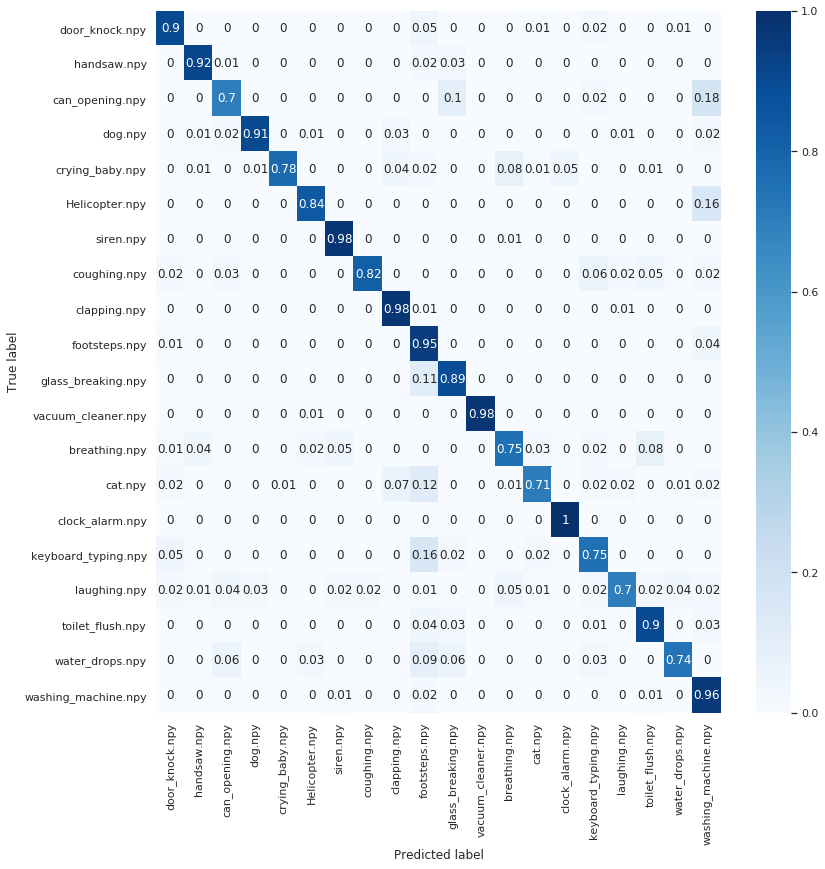

INFO:tensorflow:Confusion Matrix:
 [[ 85   0   0   0   0   0   0   0   0   5   0   0   0   1   0   2   0   0
    1   0]
 [  0 189   3   0   0   0   0   0   0   5   6   0   0   0   0   1   0   1
    0   0]
 [  0   0  28   0   0   0   0   0   0   0   4   0   0   0   0   1   0   0
    0   7]
 [  0   1   2 105   0   1   0   0   3   0   0   0   0   0   0   0   1   0
    0   2]
 [  0   1   0   1 133   0   0   0   6   3   0   0  14   2   9   0   0   1
    0   0]
 [  0   0   0   0   0 189   0   0   0   0   0   0   0   0   0   0   0   0
    0  35]
 [  0   0   0   1   0   1 235   0   0   0   0   0   2   0   0   0   0   0
    0   1]
 [  1   0   2   0   0   0   0  53   0   0   0   0   0   0   0   4   1   3
    0   1]
 [  0   0   0   0   0   0   0   0 194   2   0   0   0   0   0   0   2   0
    0   0]
 [  1   0   0   0   0   0   0   0   0 126   0   0   0   0   0   0   0   0
    0   5]
 [  0   0   0   0   0   0   0   0   0   7  55   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   3   1 

In [18]:
import pandas as pd
import seaborn as sns; sns.set()

#classes=["dog", "clock alarm", "glass breaking", "fireworks", "clapping", "door knock"]

classes=['door_knock.npy', 'handsaw.npy', 'can_opening.npy', 'dog.npy', 'crying_baby.npy', 'Helicopter.npy', \
 'siren.npy', 'coughing.npy', 'clapping.npy', 'footsteps.npy', 'glass_breaking.npy', 'vacuum_cleaner.npy',\
 'breathing.npy', 'cat.npy','clock_alarm.npy', 'keyboard_typing.npy', 'laughing.npy', 'toilet_flush.npy', 'water_drops.npy', 'washing_machine.npy']


# classes=['fireworks.npy', 'car_horn.npy', 'rain.npy', 'rooster.npy', 'sea_waves.npy', \
#          'frog.npy', 'engine.npy', 'dog.npy', 'crying_baby.npy', 'chirping_birds.npy', \
#          'Helicopter.npy', 'brushing_teeth.npy', 'siren.npy', 'coughing.npy', 'church_bells.npy',\
#          'pig.npy', 'thunderstorm.npy', 'clapping.npy', 'footsteps.npy', 'clock_tick.npy',\
#          'vacuum_cleaner.npy', 'sneezing.npy', 'breathing.npy', 'train.npy', 'cat.npy', 'cow.npy',\
#          'clock_alarm.npy', 'chainsaw.npy', 'keyboard_typing.npy', 'laughing.npy', 'hen.npy', \
#          'drinking_sipping.npy', 'toilet_flush.npy', 'snoring.npy', 'sheep.npy', 'crow.npy', 'mouse_click.npy']

real_label_batch = tf.argmax(y_test_hot, axis=1)
y_pred=model.predict_classes(X_test)
con_mat = tf.math.confusion_matrix(labels=real_label_batch, predictions=y_pred).numpy()   

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

figure = plt.figure(figsize=(12, 12))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()



tf.compat.v1.logging.info('Confusion Matrix:\n %s' % (con_mat))
tf.compat.v1.logging.info('Confusion Matrix Normalized:\n %s' % (con_mat_norm))


### Evaluating model graphically
Accuracy graph and loss graph of both training and validation.
This allows me to see if data is overfitting after a number of epochs

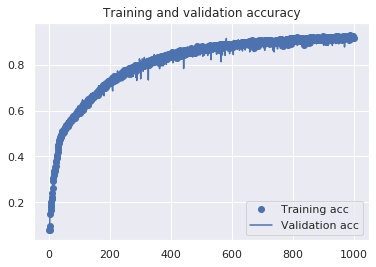

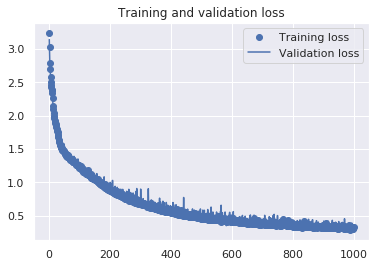

In [20]:
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs,val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

Save the graph in protobuffer format


In [21]:
eval_speech_graph = tf.Graph()
eval_speech_sess = tf.Session(graph=eval_speech_graph)

keras.backend.set_session(eval_speech_sess)
with eval_speech_graph.as_default():
    keras.backend.set_learning_phase(0)
    eval_model = build_urban_model()

    #For quantization aware training only
    #tf.contrib.quantize.create_eval_graph(input_graph=eval_speech_graph)
    eval_speech_graph_def = eval_speech_graph.as_graph_def()
    saver = tf.train.Saver()
    saver.restore(eval_speech_sess, 'checkpoints')

    frozen_graph_def = tf.graph_util.convert_variables_to_constants( eval_speech_sess, eval_speech_graph_def, 
                                                                    [eval_model.output.op.name] )

    with open('frozen_urban_model.pb', 'wb') as f:
      f.write(frozen_graph_def.SerializeToString())

INFO:tensorflow:Restoring parameters from checkpoints
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 18 variables.
INFO:tensorflow:Converted 18 variables to const ops.


In [0]:
import pathlib

tf.enable_eager_execution()
tf.logging.set_verbosity(tf.logging.DEBUG)

converter = tf.lite.TFLiteConverter.from_frozen_graph( "frozen_urban_model.pb", ["conv2d_1_input"], ["dense_2/Softmax"])
tflite_model = converter.convert()

In [0]:
tflite_models_dir = pathlib.Path("/tmp/ESC50-split-models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [24]:
tflite_model_file = tflite_models_dir/"esc50-split-model.tflite"
tflite_model_file.write_bytes(tflite_model)

225912

In [25]:
!ls -lh {tflite_models_dir}

total 224K
-rw-r--r-- 1 root root 221K Jan 25 22:43 esc50-split-model.tflite


In [0]:
# Optimize for size
tf.logging.set_verbosity(tf.logging.INFO)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

In [0]:
# Create quantized values with an accurate dynamic range of activations, 
# for that need to provide a representative dataset

#sounds = tf.cast(X_train, tf.float32)/1000.0
sounds = tf.cast(X_train, tf.float32)
urban_ds = tf.data.Dataset.from_tensor_slices((sounds)).batch(1)
def representative_data_gen():
  for input_value in urban_ds.take(100):
    yield [input_value]
    
converter.representative_dataset = representative_data_gen

In [0]:
# THIS IS NOT USED ANYMORE

# tflite format quantized
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"esc50-split-model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)

In [28]:
# tflite quantized with float inputs
tflite_quant_float_model = converter.convert()
tflite_model_quant_float_file = tflite_models_dir/"esc50-split-model_quant_float.tflite"
tflite_model_quant_float_file.write_bytes(tflite_quant_float_model)

78592

In [29]:
!ls -lh {tflite_models_dir}

total 304K
-rw-r--r-- 1 root root  77K Jan 25 22:43 esc50-split-model_quant_float.tflite
-rw-r--r-- 1 root root 221K Jan 25 22:43 esc50-split-model.tflite


In [30]:
# The converted model needs to be fully quantized. That means all ops need to be 
# quantized, no floats left. The input and outputs need to be integers too.

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()
tflite_model_quant_file = tflite_models_dir/"esc50-split-model_quant_io.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

78664

In [31]:
!ls -lh {tflite_models_dir}

total 384K
-rw-r--r-- 1 root root  77K Jan 25 22:43 esc50-split-model_quant_float.tflite
-rw-r--r-- 1 root root  77K Jan 25 22:43 esc50-split-model_quant_io.tflite
-rw-r--r-- 1 root root 221K Jan 25 22:43 esc50-split-model.tflite


In [32]:
# Load data for float model
sounds = tf.cast(X_test, tf.float32)
urban_ds = tf.data.Dataset.from_tensor_slices(sounds).batch(1)


X_train_flat = X_train.flatten()
X_train_max = max(X_train_flat)
X_train_min = min(X_train_flat)
print(X_train_max)
print(X_train_min)


# Load data for quantized model
X_test_flat = X_test.flatten()
X_test_max = max(X_test_flat)
X_test_min = min(X_test_flat)
print(X_test_max)
print(X_test_min)
quant_sounds = tf.quantization.quantize(X_test, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
#quant_sounds = tf.quantization.quantize(X_test, X_test_min, X_test_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
sounds_uint8 = tf.cast(quant_sounds[0], tf.uint8)
urban_ds_uint8 = tf.data.Dataset.from_tensor_slices(sounds_uint8).batch(1)

#print(sounds_uint8)
#print(X_test)
#print(quant_sounds[0])

3.15446410529096
-10.342365375308853
3.2024094369875056
-9.966368484617695


### run model with tflite interpreter

In [0]:
def predict(records, n):
  max = records[0]
  
  for i in range(1, n):
    if records[i] > max:
      max = records[i]

  index = record.index(max)

  return max, index

In [0]:
#Non quantized model
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [0]:
# Quantized model with float inputs and outputs
interpreter_float = tf.lite.Interpreter(model_path=str(tflite_model_quant_float_file))
interpreter_float.allocate_tensors()

In [0]:
# Quantized model with integer inputs and outputs
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()

In [0]:

#labels=['footsteps', "door_knock", "clock_alarm", 'glass breaking']
labels=['glass_breaking', 'footsteps', 'clock_alarm', 'door_knock']
for m in range(11, 30):
  print("\nRunning number", m)
  predict_number = m

  i=0
  for sound in urban_ds:
    #for list in sound:
      
      #break
    if i == predict_number:
      break
    i= i+1
    
    #print(list[1])

  #print(sound.shape)
  #print(list.shape)
  interpreter.set_tensor(interpreter.get_input_details()[0]["index"], sound)
  interpreter.invoke()
  predictions = interpreter.get_tensor(
      interpreter.get_output_details()[0]["index"])

  print(predictions)

  class_prediction = predictions.tolist()

  for record in class_prediction:
    record

  records = array(record)

  n = len(records)

  class_predicted, indice = predict(records, n)

  real_words = y_test[predict_number]
  real_word = int(real_words)
  word_predicted = labels[indice]

  print(labels)
  print("\nFLOATS")
  print('---------------------')
  print('Predicted class is ', labels[indice])
  print('Real class is ', labels[real_word])
  print('----------------------\n\n')  


  i=0
  for sound in urban_ds_uint8:
    
    if i == predict_number:
      break
    i= i+1
  #print(sound)
  interpreter_quant.set_tensor(interpreter_quant.get_input_details()[0]["index"], sound)
  interpreter_quant.invoke()
  predictions = interpreter_quant.get_tensor(
      interpreter_quant.get_output_details()[0]["index"])

  class_prediction = predictions.tolist()

  for record in class_prediction:
    record

  records = array(record)

  n = len(records)

  class_predicted, indice = predict(records, n)

  print(predictions)

  print("\n\nINTEGERS")
  print("---------------------------")

  print('Predicted class is ', labels[indice])
  print('Real class is ', labels[real_word])
  print('----------------------------') 




In [0]:
labels = ['fireworks.npy', 'car_horn.npy', 'rain.npy', 'rooster.npy', 'sea_waves.npy', 'frog.npy', 'engine.npy', 'dog.npy', 'crying_baby.npy', \
          'chirping_birds.npy', 'Helicopter.npy', 'brushing_teeth.npy', 'siren.npy', 'coughing.npy', 'church_bells.npy', 'pig.npy', 'thunderstorm.npy', \
          'clapping.npy', 'footsteps.npy', 'clock_tick.npy', 'vacuum_cleaner.npy', 'sneezing.npy', 'breathing.npy', 'train.npy', 'cat.npy', 'cow.npy', \
          'clock_alarm.npy', 'chainsaw.npy', 'keyboard_typing.npy', 'laughing.npy', 'hen.npy', 'drinking_sipping.npy', 'toilet_flush.npy',  \
          'snoring.npy', 'sheep.npy', 'crow.npy', 'mouse_click.npy']

In [0]:
['sheep', 'hen', 'vacuum_cleaner', 'dog', 'cat', 'toilet_flush', 'clapping', 'coughing', 'Helicopter', 'rooster', 'breathing', 'snoring', 'clock_tick', \
 'siren', 'pig', 'frog', 'chainsaw', 'drinking_sipping', 'keyboard_typing', 'church_bells', 'fireworks', 'sneezing', 'car_horn', 'train', 'clock_alarm',\
 'rain', 'crow', 'sea_waves', 'chirping_birds', 'engine', 'footsteps', 'crying_baby', 'mouse_click', 'laughing', 'cow', 'thunderstorm', 'brushing_teeth', \
 '_background_noise_', 'washing_machine', 'glass_breaking', 'wind', 'insects', 'can_opening', 'door_wood_creacks', 'airplane', 'pouring_water', 'handsaw', \
 'water_drops', 'door_knock', 'crickets', 'crackling_fire']

In [0]:
['fireworks.npy', 'car_horn.npy', 'rain.npy', 'rooster.npy', 'sea_waves.npy', 'frog.npy', 'engine.npy', 'dog.npy', 'crying_baby.npy', 'chirping_birds.npy',\
 'Helicopter.npy', 'brushing_teeth.npy', 'siren.npy', 'coughing.npy', 'church_bells.npy', 'pig.npy', 'thunderstorm.npy', 'clapping.npy', 'footsteps.npy',\
 'clock_tick.npy', 'vacuum_cleaner.npy', 'sneezing.npy', 'breathing.npy', 'train.npy', 'cat.npy', 'cow.npy', 'clock_alarm.npy', 'chainsaw.npy', \
 'keyboard_typing.npy', 'laughing.npy', 'hen.npy', 'drinking_sipping.npy', 'toilet_flush.npy', 'snoring.npy', 'sheep.npy', 'crow.npy', 'mouse_click.npy']

In [0]:
labels =['fireworks.npy', 'car_horn.npy', 'rain.npy', 'rooster.npy', 'sea_waves.npy', 'frog.npy', 'engine.npy', 'dog.npy', 'crying_baby.npy', \
 'chirping_birds.npy', 'Helicopter.npy', 'brushing_teeth.npy', 'siren.npy', 'coughing.npy', 'church_bells.npy', 'pig.npy', 'thunderstorm.npy',\
 'clapping.npy', 'footsteps.npy', 'clock_tick.npy', 'vacuum_cleaner.npy', 'sneezing.npy', 'breathing.npy', 'train.npy', 'cat.npy', 'cow.npy', \
 'clock_alarm.npy', 'chainsaw.npy', 'keyboard_typing.npy', 'laughing.npy', 'hen.npy', 'drinking_sipping.npy', 'toilet_flush.npy', 'snoring.npy',\
 'sheep.npy', 'crow.npy', 'mouse_click.npy']

In [37]:
# 4 labels
#labels=['glass_breaking', 'footsteps', 'clock_alarm', 'door_knock']

# 10 labels
#labels=['door_knock', 'dog', 'crying_baby', 'clapping',\
#         'footsteps', 'glass_breaking', 'vacuum_cleaner', 'cat', 'clock_alarm', 'laughing']
# 20 labels
label=['door_knock.npy', 'handsaw.npy', 'can_opening.npy', 'dog.npy', 'crying_baby.npy', 'Helicopter.npy', \
 'siren.npy', 'coughing.npy', 'clapping.npy', 'footsteps.npy', 'glass_breaking.npy', 'vacuum_cleaner.npy',\
 'breathing.npy', 'cat.npy','clock_alarm.npy', 'keyboard_typing.npy', 'laughing.npy', 'toilet_flush.npy', 'water_drops.npy', 'washing_machine.npy']
for m in range(1, 100):
  print("\nRunning number", m)
  print("\n\n")
  predict_number = m

  i=0
  for sound in urban_ds:
    #for list in sound:
      
      #break
    if i == predict_number:
      break
    i= i+1
    
    #print(list[1])

  #print(sound.shape)
  #print(list.shape)


  ###  Running non-quantized model with float inputs
  interpreter.set_tensor(interpreter.get_input_details()[0]["index"], sound)
  interpreter.invoke()
  predictions = interpreter.get_tensor(
      interpreter.get_output_details()[0]["index"])

  

  class_prediction = predictions.tolist()

  for record in class_prediction:
    record

  records = array(record)

  n = len(records)

  class_predicted, indice = predict(records, n)

  real_words = y_test[predict_number]
  real_word = int(real_words)
  word_predicted = labels[indice]

  print(labels)
  print("\nNON-QUANTIZED WITH FLOATS")
  print('---------------------')
  print('Predicted class is ', labels[indice])
  print('Real class is ', labels[real_word])
  print('----------------------\n\n')  

  print(predictions)


# Running quantized model with float inputs
  interpreter_float.set_tensor(interpreter_float.get_input_details()[0]["index"], sound)
  interpreter_float.invoke()
  predictions = interpreter_float.get_tensor(
      interpreter_float.get_output_details()[0]["index"])

  print(predictions)

  class_prediction = predictions.tolist()

  for record in class_prediction:
    record

  records = array(record)

  n = len(records)

  class_predicted, indice = predict(records, n)

  real_words = y_test[predict_number]
  real_word = int(real_words)
  word_predicted = labels[indice]

  print(labels)
  print("\nQUANTIZED WITH FLOATS")
  print('---------------------')
  print('Predicted class is ', labels[indice])
  print('Real class is ', labels[real_word])
  print('----------------------\n\n')  







  i=0
  for sound in urban_ds_uint8:
    
    if i == predict_number:
      break
    i= i+1
  #print(sound)
  interpreter_quant.set_tensor(interpreter_quant.get_input_details()[0]["index"], sound)
  interpreter_quant.invoke()
  predictions = interpreter_quant.get_tensor(
      interpreter_quant.get_output_details()[0]["index"])

  class_prediction = predictions.tolist()

  for record in class_prediction:
    record

  records = array(record)

  n = len(records)

  class_predicted, indice = predict(records, n)

  print(predictions)

  print("\n\nINTEGERS")
  print("---------------------------")

  print('Predicted class is ', labels[indice])
  print('Real class is ', labels[real_word])
  print('----------------------------') 



Running number 1



['sheep', 'hen', 'vacuum_cleaner', 'dog', 'cat', 'toilet_flush', 'clapping', 'coughing', 'Helicopter', 'rooster', 'breathing', 'snoring', 'clock_tick', 'siren', 'pig', 'frog', 'chainsaw', 'drinking_sipping', 'keyboard_typing', 'church_bells', 'fireworks', 'sneezing', 'car_horn', 'train', 'clock_alarm', 'rain', 'crow', 'sea_waves', 'chirping_birds', 'engine', 'footsteps', 'crying_baby', 'mouse_click', 'laughing', 'cow', 'thunderstorm', 'brushing_teeth', '_background_noise_', 'washing_machine', 'glass_breaking', 'wind', 'insects', 'can_opening', 'door_wood_creacks', 'airplane', 'pouring_water', 'handsaw', 'water_drops', 'door_knock', 'crickets', 'crackling_fire']

NON-QUANTIZED WITH FLOATS
---------------------
Predicted class is  clapping
Real class is  clapping
----------------------


[[1.19545120e-27 7.83103301e-18 9.45289264e-11 4.44121906e-05
  7.88528123e-05 0.00000000e+00 9.97468233e-01 1.05187664e-10
  1.45459949e-16 1.31194456e-20 3.49297170e-16 1.01845310e

# Test data preparation
This prepares single files never seen by model.
This files are used on other targets to test model.

### Normalizing the test files based on the dataset distribution worked

In [0]:
mean_data = np.mean(X)
sdt_dev_data = np.std(X)

# test file set 1
mfcc_clapping1 = urban_wav2mfcc('test_single_file/clapping/clapping-E-2-25292-A.wav', max_pad_len=51)
mfcc_dog1 = urban_wav2mfcc('test_single_file/dog/dog-A-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock1 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-2-133889-A.wav', max_pad_len=51)
mfcc_clock_alarm1 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-A-2-104476-A.wav', max_pad_len=51)
mfcc_glass_breaking1 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-1-88807-A.wav', max_pad_len=51)
mfcc_fireworks1 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-2-117615-D.wav', max_pad_len=51)



mfcc_clapping1_std = normalize_data(mfcc_clapping1, mean_data, sdt_dev_data )
mfcc_dog1_std = normalize_data(mfcc_dog1, mean_data, sdt_dev_data )
mfcc_door_knock1_std = normalize_data(mfcc_door_knock1, mean_data, sdt_dev_data )
mfcc_clock_alarm1_std = normalize_data(mfcc_clock_alarm1, mean_data, sdt_dev_data )
mfcc_glass_breaking1_std = normalize_data(mfcc_glass_breaking1 , mean_data, sdt_dev_data )
mfcc_fireworks1_std = normalize_data(mfcc_fireworks1, mean_data, sdt_dev_data )



clapping_file1 = mfcc_clapping1_std.reshape(1, MFCC, 51, 1)
dog_file1 = mfcc_dog1_std.reshape(1, MFCC, 51, 1)
door_knock_file1 = mfcc_door_knock1_std.reshape(1, MFCC, 51, 1)
clock_alarm_file1 = mfcc_clock_alarm1_std.reshape(1, MFCC, 51, 1)
glass_breaking_file1 = mfcc_glass_breaking1_std.reshape(1, MFCC, 51, 1)
fireworks_file1 = mfcc_fireworks1_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'clapping_single1.npy', clapping_file1)
np.save('/content/' + 'dog_single1.npy', dog_file1)
np.save('/content/' + 'door_knock_single1.npy', door_knock_file1 )
np.save('/content/' + 'clock_alarm_single1.npy', clock_alarm_file1 )
np.save('/content/' + 'glass_breaking_single1.npy', glass_breaking_file1)
np.save('/content/' + 'fireworks_single1.npy', fireworks_file1)



# test file set 2
mfcc_clapping2 = urban_wav2mfcc('test_single_file/clapping/clapping-E-3-177082-A.wav', max_pad_len=51)
mfcc_dog2 = urban_wav2mfcc('test_single_file/dog/dog-E-3-144028-A.wav', max_pad_len=51)
mfcc_door_knock2 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-5-250026-B.wav', max_pad_len=51)
mfcc_clock_alarm2 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-117883-A.wav', max_pad_len=51)
mfcc_glass_breaking2 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-4-212698-A.wav', max_pad_len=51)
mfcc_fireworks2 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-4-119648-A.wav', max_pad_len=51)


mfcc_clapping2_std = normalize_data(mfcc_clapping2, mean_data, sdt_dev_data )
mfcc_dog2_std = normalize_data(mfcc_dog2, mean_data, sdt_dev_data )
mfcc_door_knock2_std = normalize_data(mfcc_door_knock2, mean_data, sdt_dev_data )
mfcc_clock_alarm2_std = normalize_data(mfcc_clock_alarm2, mean_data, sdt_dev_data )
mfcc_glass_breaking2_std = normalize_data(mfcc_glass_breaking2 , mean_data, sdt_dev_data )
mfcc_fireworks2_std = normalize_data(mfcc_fireworks2, mean_data, sdt_dev_data )


dog_file2 = mfcc_dog2_std.reshape(1, MFCC, 51, 1)
clapping_file2 = mfcc_clapping2_std.reshape(1, MFCC, 51, 1)
door_knock_file2 = mfcc_door_knock2_std.reshape(1, MFCC, 51, 1)
clock_alarm_file2 = mfcc_clock_alarm2_std.reshape(1, MFCC, 51, 1)
glass_breaking_file2 = mfcc_glass_breaking2_std.reshape(1, MFCC, 51, 1)
fireworks_file2 = mfcc_fireworks2_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single2.npy', dog_file2)
np.save('/content/' + 'clapping_single2.npy', clapping_file2)
np.save('/content/' + 'door_knock_single2.npy', door_knock_file2 )
np.save('/content/' + 'clock_alarm_single2.npy', clock_alarm_file2 )
np.save('/content/' + 'glass_breaking_single2.npy', glass_breaking_file2)
np.save('/content/' + 'fireworks_single2.npy', fireworks_file2)



# test file set 3
mfcc_clapping3 = urban_wav2mfcc('test_single_file/clapping/clapping-E-4-189828-A.wav', max_pad_len=51)
mfcc_dog3 = urban_wav2mfcc('test_single_file/dog/dog-D-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock3 = urban_wav2mfcc('test_single_file/door_knock/door_knock-B-1-101336-A.wav', max_pad_len=51)
mfcc_clock_alarm3 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-132340-A.wav', max_pad_len=51)
mfcc_glass_breaking3 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-B-4-204777-B.wav', max_pad_len=51)
mfcc_fireworks3 = urban_wav2mfcc('test_single_file/fireworks/fireworks-E-2-117617-A.wav', max_pad_len=51)


mfcc_clapping3_std = normalize_data(mfcc_clapping3, mean_data, sdt_dev_data )
mfcc_dog3_std = normalize_data(mfcc_dog3, mean_data, sdt_dev_data )
mfcc_door_knock3_std = normalize_data(mfcc_door_knock3, mean_data, sdt_dev_data )
mfcc_clock_alarm3_std = normalize_data(mfcc_clock_alarm3, mean_data, sdt_dev_data )
mfcc_glass_breaking3_std = normalize_data(mfcc_glass_breaking3 , mean_data, sdt_dev_data )
mfcc_fireworks3_std = normalize_data(mfcc_fireworks3, mean_data, sdt_dev_data )


dog_file3 = mfcc_dog3_std.reshape(1, MFCC, 51, 1)
clapping_file3 = mfcc_clapping3_std.reshape(1, MFCC, 51, 1)
door_knock_file3 = mfcc_door_knock3_std.reshape(1, MFCC, 51, 1)
clock_alarm_file3 = mfcc_clock_alarm3_std.reshape(1, MFCC, 51, 1)
glass_breaking_file3 = mfcc_glass_breaking3_std.reshape(1, MFCC, 51, 1)
fireworks_file3 = mfcc_fireworks3_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single3.npy', dog_file3)
np.save('/content/' + 'clapping_single3.npy', clapping_file3)
np.save('/content/' + 'door_knock_single3.npy', door_knock_file3 )
np.save('/content/' + 'clock_alarm_single3.npy', clock_alarm_file3 )
np.save('/content/' + 'glass_breaking_single3.npy', glass_breaking_file3)
np.save('/content/' + 'fireworks_single3.npy', fireworks_file3)

### The test files worked with dataset distribution parameters

In [0]:
#data1
dog_flat = dog_file1.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_1 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file1.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_1 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file1.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_1 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file1.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_1 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file1.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_1 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file1.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file1, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_1 = tf.cast(quant_fireworks[0], tf.uint8)





#data2
dog_flat = dog_file2.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_2 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file2.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_2 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file2.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_2 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file2.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_2 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file2.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_2 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file2.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file2, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_2 = tf.cast(quant_fireworks[0], tf.uint8)



#data3
dog_flat = dog_file3.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file3, X_train_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_3 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file3.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_3 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file3.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_3 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file3.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_3 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file3.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_3 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file3.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file3, X_train_min, X_train_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_3 = tf.cast(quant_fireworks[0], tf.uint8)                                           

In [0]:
np.save('/content/' + 'dog_single_uint8_1.npy', dog_uint8_1)
np.save('/content/' + 'clapping_single_uint8_1.npy', clapping_uint8_1)
np.save('/content/' + 'door_knock_single_uint8_1.npy', door_knock_uint8_1)
np.save('/content/' + 'clock_alarm_single_uint8_1.npy', clock_alarm_uint8_1 )
np.save('/content/' + 'glass_breaking_single_uint8_1.npy', glass_breaking_uint8_1)
np.save('/content/' + 'fireworks_single_uint8_1.npy', fireworks_uint8_1 )


np.save('/content/' + 'dog_single_uint8_2.npy', dog_uint8_2)
np.save('/content/' + 'clapping_single_uint8_2.npy', clapping_uint8_2)
np.save('/content/' + 'door_knock_single_uint8_2.npy', door_knock_uint8_2)
np.save('/content/' + 'clock_alarm_single_uint8_2.npy', clock_alarm_uint8_2 )
np.save('/content/' + 'glass_breaking_single_uint8_2.npy', glass_breaking_uint8_2)
np.save('/content/' + 'fireworks_single_uint8_2.npy', fireworks_uint8_2 )



np.save('/content/' + 'dog_single_uint8_3.npy', dog_uint8_3)
np.save('/content/' + 'clapping_single_uint8_3.npy', clapping_uint8_3)
np.save('/content/' + 'door_knock_single_uint8_3.npy', door_knock_uint8_3)
np.save('/content/' + 'clock_alarm_single_uint8_3.npy', clock_alarm_uint8_3 )
np.save('/content/' + 'glass_breaking_single_uint8_3.npy', glass_breaking_uint8_3)
np.save('/content/' + 'fireworks_single_uint8_3.npy', fireworks_uint8_3 )


## Bad test data 

---



### Normalizing the test files individually did not work

In [0]:
#mean_data = np.mean(X)
#sdt_dev_data = np.std(X)


# test file set 1
mfcc_clapping1 = urban_wav2mfcc('test_single_file/clapping/clapping-E-2-25292-A.wav', max_pad_len=51)
mfcc_dog1 = urban_wav2mfcc('test_single_file/dog/dog-A-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock1 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-2-133889-A.wav', max_pad_len=51)
mfcc_clock_alarm1 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-A-2-104476-A.wav', max_pad_len=51)
mfcc_glass_breaking1 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-1-88807-A.wav', max_pad_len=51)
mfcc_fireworks1 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-2-117615-D.wav', max_pad_len=51)

# MEAN set 1
clapping1_mean = np.mean(mfcc_clapping1)
dog1_mean = np.mean(mfcc_dog1)
door_knock1_mean = np.mean(mfcc_door_knock1)
clock_alarm1_mean = np.mean(mfcc_clock_alarm1)
glass_breaking1_mean = np.mean(mfcc_glass_breaking1)
fireworks1_mean = np.mean(mfcc_fireworks1)

#STANDARD DEVIATION set 1
clapping1_std = np.std(mfcc_clapping1)
dog1_std = np.std(mfcc_dog1)
door_knock1_std = np.std(mfcc_door_knock1)
clock_alarm1_std = np.std(mfcc_clock_alarm1)
glass_breaking1_std = np.std(mfcc_glass_breaking1)
fireworks1_std = np.std(mfcc_fireworks1)



mfcc_clapping1_std = normalize_data(mfcc_clapping1, clapping1_mean, clapping1_std )
mfcc_dog1_std = normalize_data(mfcc_dog1, dog1_mean, dog1_std )
mfcc_door_knock1_std = normalize_data(mfcc_door_knock1, door_knock1_mean, door_knock1_std  )
mfcc_clock_alarm1_std = normalize_data(mfcc_clock_alarm1, clock_alarm1_mean, clock_alarm1_std )
mfcc_glass_breaking1_std = normalize_data(mfcc_glass_breaking1 , glass_breaking1_mean, glass_breaking1_std )
mfcc_fireworks1_std = normalize_data(mfcc_fireworks1, fireworks1_mean, fireworks1_std )



clapping_file1 = mfcc_clapping1_std.reshape(1, MFCC, 51, 1)
dog_file1 = mfcc_dog1_std.reshape(1, MFCC, 51, 1)
door_knock_file1 = mfcc_door_knock1_std.reshape(1, MFCC, 51, 1)
clock_alarm_file1 = mfcc_clock_alarm1_std.reshape(1, MFCC, 51, 1)
glass_breaking_file1 = mfcc_glass_breaking1_std.reshape(1, MFCC, 51, 1)
fireworks_file1 = mfcc_fireworks1_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'clapping_single1.npy', clapping_file1)
np.save('/content/' + 'dog_single1.npy', dog_file1)
np.save('/content/' + 'door_knock_single1.npy', door_knock_file1 )
np.save('/content/' + 'clock_alarm_single1.npy', clock_alarm_file1 )
np.save('/content/' + 'glass_breaking_single1.npy', glass_breaking_file1)
np.save('/content/' + 'fireworks_single1.npy', fireworks_file1)



# test file set 2
mfcc_clapping2 = urban_wav2mfcc('test_single_file/clapping/clapping-E-3-177082-A.wav', max_pad_len=51)
mfcc_dog2 = urban_wav2mfcc('test_single_file/dog/dog-E-3-144028-A.wav', max_pad_len=51)
mfcc_door_knock2 = urban_wav2mfcc('test_single_file/door_knock/door_knock-A-5-250026-B.wav', max_pad_len=51)
mfcc_clock_alarm2 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-117883-A.wav', max_pad_len=51)
mfcc_glass_breaking2 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-A-4-212698-A.wav', max_pad_len=51)
mfcc_fireworks2 = urban_wav2mfcc('test_single_file/fireworks/fireworks-A-4-119648-A.wav', max_pad_len=51)


# MEAN set 2
clapping2_mean = np.mean(mfcc_clapping2)
dog2_mean = np.mean(mfcc_dog2)
door_knock2_mean = np.mean(mfcc_door_knock2)
clock_alarm2_mean = np.mean(mfcc_clock_alarm2)
glass_breaking2_mean = np.mean(mfcc_glass_breaking2)
fireworks2_mean = np.mean(mfcc_fireworks2)

#STANDARD DEVIATION set 2
clapping2_std = np.std(mfcc_clapping2)
dog2_std = np.std(mfcc_dog2)
door_knock2_std = np.std(mfcc_door_knock2)
clock_alarm2_std = np.std(mfcc_clock_alarm2)
glass_breaking2_std = np.std(mfcc_glass_breaking2)
fireworks2_std = np.std(mfcc_fireworks2)



mfcc_clapping2_std = normalize_data(mfcc_clapping2, clapping2_mean, clapping2_std )
mfcc_dog2_std = normalize_data(mfcc_dog2, dog2_mean, dog2_std )
mfcc_door_knock2_std = normalize_data(mfcc_door_knock2, door_knock2_mean, door_knock2_std  )
mfcc_clock_alarm2_std = normalize_data(mfcc_clock_alarm2, clock_alarm2_mean, clock_alarm2_std )
mfcc_glass_breaking2_std = normalize_data(mfcc_glass_breaking2 , glass_breaking2_mean, glass_breaking2_std )
mfcc_fireworks2_std = normalize_data(mfcc_fireworks2, fireworks2_mean, fireworks2_std )



dog_file2 = mfcc_dog2_std.reshape(1, MFCC, 51, 1)
clapping_file2 = mfcc_clapping2_std.reshape(1, MFCC, 51, 1)
door_knock_file2 = mfcc_door_knock2_std.reshape(1, MFCC, 51, 1)
clock_alarm_file2 = mfcc_clock_alarm2_std.reshape(1, MFCC, 51, 1)
glass_breaking_file2 = mfcc_glass_breaking2_std.reshape(1, MFCC, 51, 1)
fireworks_file2 = mfcc_fireworks2_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single2.npy', dog_file2)
np.save('/content/' + 'clapping_single2.npy', clapping_file2)
np.save('/content/' + 'door_knock_single2.npy', door_knock_file2 )
np.save('/content/' + 'clock_alarm_single2.npy', clock_alarm_file2 )
np.save('/content/' + 'glass_breaking_single2.npy', glass_breaking_file2)
np.save('/content/' + 'fireworks_single2.npy', fireworks_file2)



# test file set 3
mfcc_clapping3 = urban_wav2mfcc('test_single_file/clapping/clapping-E-4-189828-A.wav', max_pad_len=51)
mfcc_dog3 = urban_wav2mfcc('test_single_file/dog/dog-D-5-208030-A.wav', max_pad_len=51)
mfcc_door_knock3 = urban_wav2mfcc('test_single_file/door_knock/door_knock-B-1-101336-A.wav', max_pad_len=51)
mfcc_clock_alarm3 = urban_wav2mfcc('test_single_file/clock_alarm/clock_alarm-B-3-132340-A.wav', max_pad_len=51)
mfcc_glass_breaking3 = urban_wav2mfcc('test_single_file/glass_breaking/glass_breaking-B-4-204777-B.wav', max_pad_len=51)
mfcc_fireworks3 = urban_wav2mfcc('test_single_file/fireworks/fireworks-E-2-117617-A.wav', max_pad_len=51)


# MEAN set 3
clapping3_mean = np.mean(mfcc_clapping3)
dog3_mean = np.mean(mfcc_dog3)
door_knock3_mean = np.mean(mfcc_door_knock3)
clock_alarm3_mean = np.mean(mfcc_clock_alarm3)
glass_breaking3_mean = np.mean(mfcc_glass_breaking3)
fireworks3_mean = np.mean(mfcc_fireworks3)

#STANDARD DEVIATION set3
clapping3_std = np.std(mfcc_clapping3)
dog3_std = np.std(mfcc_dog3)
door_knock3_std = np.std(mfcc_door_knock3)
clock_alarm3_std = np.std(mfcc_clock_alarm3)
glass_breaking3_std = np.std(mfcc_glass_breaking3)
fireworks3_std = np.std(mfcc_fireworks3)


mfcc_clapping3_std = normalize_data(mfcc_clapping3, clapping3_mean, clapping3_std )
mfcc_dog3_std = normalize_data(mfcc_dog3, dog3_mean, dog3_std )
mfcc_door_knock3_std = normalize_data(mfcc_door_knock3, door_knock3_mean, door_knock3_std)
mfcc_clock_alarm3_std = normalize_data(mfcc_clock_alarm3, clock_alarm3_mean, clock_alarm3_std )
mfcc_glass_breaking3_std = normalize_data(mfcc_glass_breaking3 , glass_breaking3_mean , glass_breaking3_std)
mfcc_fireworks3_std = normalize_data(mfcc_fireworks3, fireworks3_mean, fireworks3_std )


dog_file3 = mfcc_dog3_std.reshape(1, MFCC, 51, 1)
clapping_file3 = mfcc_clapping3_std.reshape(1, MFCC, 51, 1)
door_knock_file3 = mfcc_door_knock3_std.reshape(1, MFCC, 51, 1)
clock_alarm_file3 = mfcc_clock_alarm3_std.reshape(1, MFCC, 51, 1)
glass_breaking_file3 = mfcc_glass_breaking3_std.reshape(1, MFCC, 51, 1)
fireworks_file3 = mfcc_fireworks3_std.reshape(1, MFCC, 51, 1)


np.save('/content/' + 'dog_single3.npy', dog_file3)
np.save('/content/' + 'clapping_single3.npy', clapping_file3)
np.save('/content/' + 'door_knock_single3.npy', door_knock_file3 )
np.save('/content/' + 'clock_alarm_single3.npy', clock_alarm_file3 )
np.save('/content/' + 'glass_breaking_single3.npy', glass_breaking_file3)
np.save('/content/' + 'fireworks_single3.npy', fireworks_file3)




### The test files normalized individually did not work

In [0]:
#data1
dog_flat = dog_file1.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file1, dog_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_1 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file1.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file1, clapping_min, clapping_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_1 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file1.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file1, door_knock_min , door_knock_max , tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_1 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file1.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file1, clock_alarm_min, clock_alarm_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_1 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file1.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file1, glass_breaking_min, glass_breaking_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_1 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file1.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file1, fireworks_min, fireworks_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_1 = tf.cast(quant_fireworks[0], tf.uint8)





#data2
dog_flat = dog_file2.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file2, dog_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_2 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file2.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file2, clapping_min, clapping_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_2 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file2.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file2, door_knock_min, door_knock_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_2 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file2.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file2, clock_alarm_min, clock_alarm_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_2 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file2.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file2, glass_breaking_min, glass_breaking_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_2 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file2.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file2, fireworks_min, fireworks_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_2 = tf.cast(quant_fireworks[0], tf.uint8)



#data3
dog_flat = dog_file3.flatten()
dog_min = min(dog_flat)
dog_max = max(dog_flat)
quant_dog = tf.quantization.quantize(dog_file3, dog_min, dog_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
dog_uint8_3 = tf.cast(quant_dog[0], tf.uint8)

clapping_flat = clapping_file3.flatten()
clapping_min = min(clapping_flat)
clapping_max = max(clapping_flat)
quant_clapping = tf.quantization.quantize(clapping_file3, clapping_min, clapping_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clapping_uint8_3 = tf.cast(quant_clapping[0], tf.uint8)

door_knock_flat = door_knock_file3.flatten()
door_knock_min = min(door_knock_flat)
door_knock_max = max(door_knock_flat)
quant_door_knock = tf.quantization.quantize(door_knock_file3, door_knock_min, door_knock_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
door_knock_uint8_3 = tf.cast(quant_door_knock[0], tf.uint8)

clock_alarm_flat = clock_alarm_file3.flatten()
clock_alarm_min = min(clock_alarm_flat)
clock_alarm_max = max(clock_alarm_flat)
quant_clock_alarm = tf.quantization.quantize(clock_alarm_file3, clock_alarm_min, clock_alarm_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
clock_alarm_uint8_3 = tf.cast(quant_clock_alarm[0], tf.uint8)

glass_breaking_flat = glass_breaking_file3.flatten()
glass_breaking_min = min(glass_breaking_flat)
glass_breaking_max = max(glass_breaking_flat)
quant_glass_breaking = tf.quantization.quantize(glass_breaking_file3, glass_breaking_min, glass_breaking_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
glass_breaking_uint8_3 = tf.cast(quant_glass_breaking[0], tf.uint8)

fireworks_flat = fireworks_file3.flatten()
fireworks_min = min(fireworks_flat)
fireworks_max = max(fireworks_flat)
quant_fireworks = tf.quantization.quantize(fireworks_file3, fireworks_min, fireworks_max, tf.quint8, mode="MIN_COMBINED", round_mode="HALF_AWAY_FROM_ZERO", name=None)
fireworks_uint8_3 = tf.cast(quant_fireworks[0], tf.uint8)